# Evaluating Laplacian score for feature selection

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/decarpentierg/laplacian-score-4-time-series/blob/main/doc/evaluate_laplacian_score.ipynb)

**Authors:** Gonzague De Carpentier, Jérémie Dentan

The goal of this notebook is to conduct some experiments to evaluate the Laplacian score for feature selection as introduced by [1] fo feature selection. Our experiments focus on **feature selection for classification of times series**.

**Some details about the comparison:**
- We use three time serie datasets: [2], [3], and [4]. Those datasets have various length (from TODO to TODO), number of sample (from TODO to TODO) and number of classes (TODO).
- The features are extracted from the time series using library TSFEL [5]
- We compare the laplacian score with two other feature selection techniques:
    - Feature selection using a threshold on the variance
    - Feature selection using the F-value of ANOVA [6] 
- For the comparison of the classification performances, we use scikit-learn SVC classifier with default parameters


**References:**
- [1] : *Laplacian Score for feature selection*, Xiaofei He,  Deng Cai, Partha Niyogi. 2005. In *Advances in Neural Information Processing Systems*.
- [2] : Jason Lines, A. Bagnall, https://timeseriesclassification.com/description.php?Dataset=SmallKitchenAppliances
- [3] : https://timeseriesclassification.com/description.php?Dataset=DiatomSizeReduction
- [4] : M. Guillame-Bert, https://timeseriesclassification.com/description.php?Dataset=PigAirwayPressure
- [5] : Time Series Feature Extraction Library, https://tsfel.readthedocs.io 
- [6] : *The Analysis of Variance*, Henry scheffé. 1999. *John Wiley & Sons*

## Set up

You should run this notebook with `Python 3.9`. Moreover, this notebook is supposed to work with the code of repository [https://github.com/decarpentierg/laplacian-score-4-time-series](https://github.com/decarpentierg/laplacian-score-4-time-series), having the dependencies in `requirements.txt` installed and with your PYTHONPATH set to the root of the repository.

The following lines should do this for you. The first outputed line after the verbose should be a path to the root of the repository:
- If you are using this notebook directly from the repository, please set `CLONE_REPO=False` 
- If you are using this notebook as a standalone, please set `CLONE_REPO=True`

In [1]:
CLONE_REPO = False

In [2]:
from pathlib import Path
import os

REPO_NAME = 'laplacian-score-4-time-series'
REQUIREMENTS = 'requirements.txt'

# If all of this already have been done
if Path(os.getcwd()).name == REPO_NAME and Path('requirements.txt').exists():
    print('We are already at the root of the repo!')
    CLONE_REPO = False

# If we need to clone the repo but it's already here
if CLONE_REPO and Path(REPO_NAME).exists():
    print("The repository already exists!")
    CLONE_REPO = False
    os.chdir(REPO_NAME)
    assert Path(REQUIREMENTS).exists(), "There exists an incomplete version of the repository, please delete it and try again"

# If we need to clone the repo and it isn't here
os.environ['CLONE_REPO'] = str(CLONE_REPO)
!if [ "$CLONE_REPO" = "True" ]; then git clone https://github.com/decarpentierg/laplacian-score-4-time-series; fi
if CLONE_REPO:
    os.chdir(REPO_NAME)
    CLONE_REPO = False

# If the notebook is already in the repo, we simply need to move to the root
if not CLONE_REPO:
    while not (Path('requirements.txt')).exists():
        os.chdir('..')

# Installing dependencies, setting PYTHONPATH
print('This should be the root of the repo:')
!pwd
%pip install -r requirements.txt --quiet
!export PYTHONPATH=$(pwd)
print("All dependencies have been installed, you're ready to go!")

This should be the root of the repo:
/Users/jeremie/Documents/02-Scolarité/01-MVA/03-Cours_S2/02-TimeSeries/laplacian-score-4-time-series
Note: you may need to restart the kernel to use updated packages.
All dependencies have been installed, you're ready to go!


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.experiments.datasets import kitchen_ds
from src.experiments import laplacian_score
from src.experiments.classifiers import get_svc_accuracy

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

        5566ms INFO  [datasets.py] Initiating dataset SmallKitchenAppliances
        5566ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=SmallKitchenAppliances
        5569ms INFO  [datasets.py] Initiating dataset DiatomSizeReduction
        5570ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=DiatomSizeReduction
        5574ms INFO  [datasets.py] Initiating dataset PigAirwayPressure
        5574ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=PigAirwayPressure


## Influence of the parameter sigma

First, let's have a look at the influence of the parameter `sigma` for the performances of the Laplacian score for feature selection. For this demonstration, we will use the `SmallKitchenAppliances` [2] dataset. The following object is of type `src.experiments.datasets.Dataset`, and have some attributes that are cached on the disk: the features as extracted by TSFEL, the distance matrix with respect to the DTW distance, the distance matrix with respect to the euclidian distance, etc. In particular, the computation of the distance matrix for DTW is pretty long, about 30min for this dataset, but the repository stored a precomputed version of this matrix.

In [8]:
dataset = kitchen_ds
dtw_matrix = dataset.dtw_distance_matrix

print(f'Shape of the features: (n_feat, n_sample)={dataset.features.shape}')
print(f'Shape of the DTW dist matrix: (n_sample, n_sample)={dtw_matrix.shape})')
print(f'Mean value of the DTW distance matrix: {dtw_matrix.mean():.2f}')

Shape of the features: (n_feat, n_sample)=(389, 750)
Shape of the DTW dist matrix: (n_sample, n_sample)=(750, 750))
Mean value of the DTW distance matrix: 163.96
Mean value of the DTW distance matrix: 37.81


Now, let's plot some histograms of the distribution of the Laplacian score when `sigma` varies. To do so, we fix the number of neighbors, for example to `25`. Moreover, we will focus on the ratio `sigma/dtw_matrix.mean()`, which makes more sense than the raw value of `sigma`.

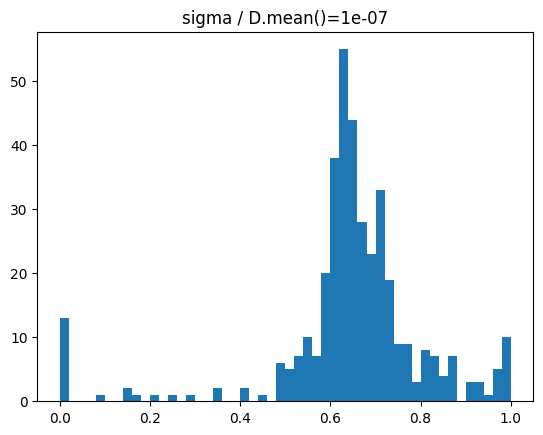

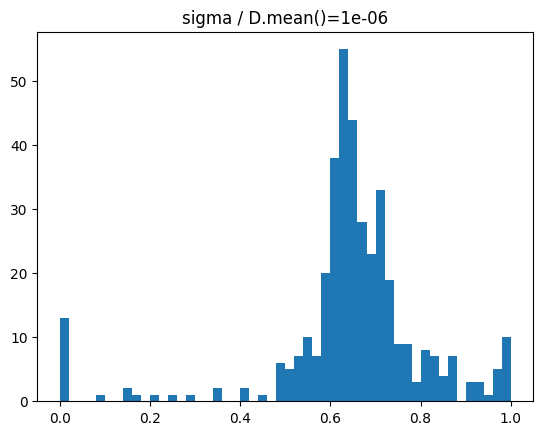

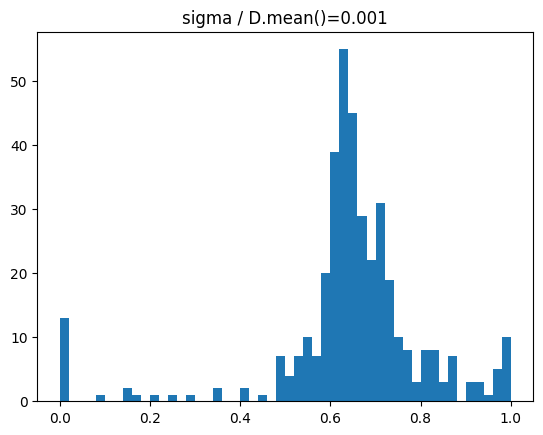

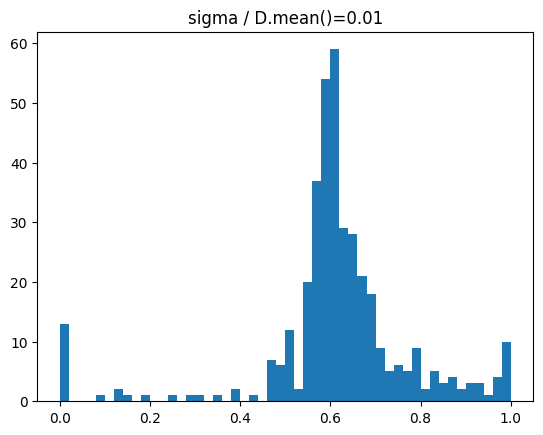

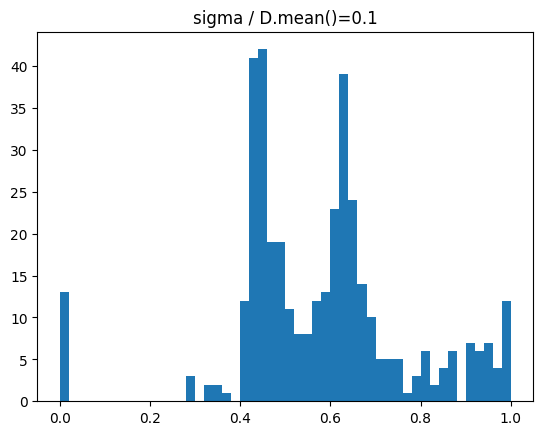

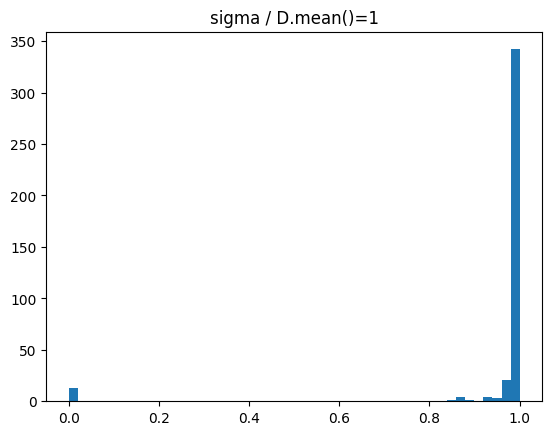

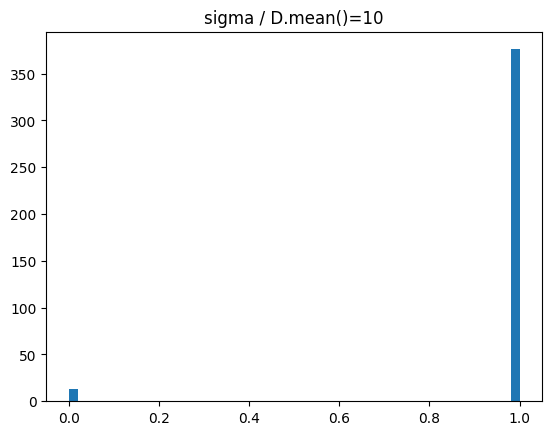

In [5]:
N_NEIGHBORS = 20

mean = dtw_matrix.mean()
for sigma_rel in [1e-7,1e-6, 1e-3, 1e-2, 1e-1, 1, 10]:
    weight_matrix = laplacian_score.compute_weight_matrix(dataset, n_neighbors=N_NEIGHBORS, sigma=sigma_rel * mean, precomputed_distances=dtw_matrix)
    lscores = laplacian_score.laplacian_score(dataset.features, weight_matrix)
    plt.hist(lscores, bins=50)
    plt.title(f'sigma / D.mean()={sigma_rel}')
    plt.show()

**Observations:**
- First, we observe that there is two quasi-stationary phases, one when `sigma` is really small, and one when `sigma` is really large. This is not surprising:
    - When `sigma` is really small, each point can nearly see only itself; indeed when the variance tends to zero, the gaussian distribution concentrates around zero, which mean that the values of the neighbors of one serie have nearly no importance for the computation of the Laplacian score
    - When `sigma`is really large, each neighbor of a time series have nearly the same importance, resulting in nearly the same value of the Laplacian score for every features (TODO: better interpretation).
- Thus, the values of `sigma` that will be of interest are the ones that are between those two stationary phases, i.e. for `sigma / dtw_matrix.mean()` between 0.001 and 0.1.

Now, let's have a closer look of what happen for the performance for `sigma` between 0.001 and 0.1.

100%|██████████| 300/300 [01:45<00:00,  2.84it/s]


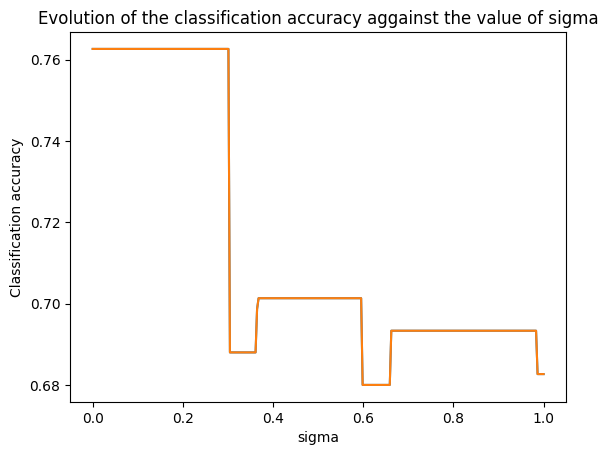

In [11]:
LOW = 1e-4
HIGH = 1
NB_POINT = 300
N_FEATURES = 10
N_NEIGHBORS = 20

sigma_values = np.linspace(LOW, HIGH, NB_POINT)
accuracy_values = list()

for sigma in tqdm(sigma_values):
    feature_selector = laplacian_score.LaplacianSelection(
        dataset,
        use_dtw=False,
        sigma=dataset.ned_distance_matrix.mean() * sigma,
        n_neighbors=N_NEIGHBORS,
        n_features=N_FEATURES,
    )
    accuracy_values.append(
        get_svc_accuracy(
            dataset.features.T,
            dataset.labels,
            feature_selector,
        )
    )


plt.plot(sigma_values, accuracy_values)
plt.xlabel('sigma')
plt.ylabel('Classification accuracy')
plt.title('Evolution of the classification accuracy aggainst the value of sigma')
plt.show()
plt.close()